Seminar V - Simulation-based estimation and inference
========================================================
#### Matěj Nevrla
##### November 2nd and 3rd, 2020 ######

You will need the packages `boot` for bootstrapping and `msm` for `deltamethod`.

In [ ]:
#install.packages(c("boot","msm"))
library(boot)
library(msm)

## 1. Normal distribution
Assume random sample from Normal distribution $N(\mu, \sigma^2)$. Let us check the biasness and _s.e._ of the __mean__ (as an estimator of $\mu$) using "brute force" bootstrapping and then using the `boot` package. 

In [ ]:
# generate the data from normal distribution 
rm(list = ls()) # clear the memory

set.seed(345) # replicate results

data    = rnorm(500, 0, 1)
mu.hat  = mean(data)
sprintf("Sample mean: %.4f", mu.hat)

sigmahat    = sd(data)
sprintf("Sample standard deviation: %.4f", sigmahat)

options(repr.plot.width = 12, repr.plot.height = 6)
par(mfcol = c(1,2)) # create a subplot 1x2
hist(data, prob = TRUE, breaks = 50, main = "Histogram", xlim = c(-3 + mu.hat, mu.hat + 3))
lines(density(data, kernel = "gaussian"), col = "red", lwd = 3) # kernel density approximation
curve(dnorm(x, mean = 0, sd = 1), col = "blue", lwd = 1, add = TRUE) # theoretical standard normal density
qqnorm(data) # normal q-q plot
qqline(data, datax = FALSE)

$bias(\widehat{\mu}) = E[\hat{\mu} - \mu] = E[\hat{\mu}] - \mu$

Since both $E[\widehat{\mu}]$ as well as $\mu$ is unknown, we approximate the first with the mean of the bootstrap replications and the second with the value of estimator itself:

$bias(\widehat{\mu})=\overline{\mu_B}-\widehat{\mu} = \frac{1}{B}\sum\limits_{b=1}^B \widehat{\mu}(b)_m-\widehat{\mu}$

We can also compute bias reduced value of the estimate using the theoretical formula

$\widehat{\mu}_{n,bias~reduced}=\widehat{\mu}-bias(\widehat{\mu})=\widehat{\mu}-\{E[\widehat{\mu}]-\mu\} ,$

which can be approximated using bootstrap as 

$\widehat{\mu}_{n,bias~reduced}=\widehat{\mu}-\Big[\frac{1}{B}\sum\limits_{b=1}^B \widehat{\mu}(b)_m-\widehat{\mu}\Big]=2\widehat{\mu}-\overline{\mu_B} .$

In [ ]:
# brute force bootstraping
Boot    = 99999
mu.boot = rep(0, Boot)

set.seed(345)
for (i in 1:Boot) {
  # nonparametric bootstrap
  data.boot     = sample(data, size = length(data), replace = TRUE)
  mu.boot[i]    = mean(data.boot)
}

# bias
sprintf("Bootstrap mean: %.4f, bootstrap bias: %.4f", mean(mu.boot), mean(mu.boot) - mu.hat)
sprintf("Bootstrap s.e. for the mean: %.4f", sd(mu.boot))
sprintf("Bias reduced estimate of mean: %.4f",2 * mu.hat - mean(mu.boot))

Analytic mean standard errors $se(\widehat{\mu})=\frac{\widehat{\sigma}}{\sqrt{T}}$.

In [ ]:
# analytic formula for sample mean s.e.
se.mu.hat       = sigmahat/sqrt(length(data))
se.mu.hat.boot  = sd(mu.boot)
sprintf("Analytic mean s.e. calculation (sigmahat/sqrt(T)): %.4f", se.mu.hat)
sprintf("Bootstrap mean s.e. calculation : %.4f", se.mu.hat.boot)

Let us check how the analytic mean standard errors compare with bootstrap values from `boot` package.

In [ ]:
# now, using the "boot" package
mean.boot = function(x, idx) {
  out = mean(x[idx])
  out
}

set.seed(345)
normal.mean.boot = boot(data, statistic = mean.boot, R = Boot)
normal.mean.boot # the result is the same as in "brute force"

# confidence intervals and plot
boot.ci(normal.mean.boot, conf = 0.95, type = c("norm", "perc"))
plot(normal.mean.boot)

We notice that the results from _brute force_ and `boot` command are the same.

## 2. Problem 11.2 (CT)
_Generate a sample of size 20 from the following dgp (data generating process). The two regressors are generated by $x_1\sim \chi^2(4)-4$, $x_2\sim 3.5+U[1,2]$. The error term is from a mixture of normals with $u\sim N[0,25]$ with probability 0.3 and $u\sim N[0,5]$ with probability 0.7; the dependend variable $y=1.3x_1+0.7x_2+0.5u$._

We generate the data acording to the instructions given by the exercise. After generation of the data it is a good idea to plot the matrix (see below) in order to see how the data look like.

In [ ]:
# create the dgp
rm(list = ls()) # clear the memory

set.seed(345) # replicate results
n   = 20 # sample size
x1  = rchisq(n, 4) - 4
x2  = 3.5 + runif(n, 1, 2)

theta   = 0.3 # theta is probability of u being from N(0,25), 1-theta probability for u from N(0,5)
mat     = cbind(rnorm(n, mean = 0, sd = 5), rnorm(n, mean = 0, sd = sqrt(5)))
u       = ifelse(runif(n) < theta, mat[ , 1], mat[ , 2])

y           = 1.3 * x1 + 0.7 * x2 + 0.5 * u
gen.data    = data.frame(y, x1, x2)

options(repr.plot.width = 6, repr.plot.height = 6)
plot(gen.data)

### a)
_Estimate by OLS the model $y=\beta_0+\beta_1 x_1 + \beta_2 x_2 + u$._

This point is quite easy, we just run the usual OLS. Even if the dgp came from a model with coefficient "0.7" we estimate $\approx -1.9$ for $x_2$ from OLS. The reason is that the error term affects much more the coefficient of $x_2$ due to the lower variance in comparison with $x_1$, $var(x_1)=9.822, var(x_2)=0.068$.

In [ ]:
m1 = lm(y ~ x1 + x2)
summary(m1)

Try to generate $y=1.3x_1+0.7x_2+0.0005u$ and check the OLS estimates.

In [ ]:
y.alt           = 1.3 * x1 + 0.7 * x2 + 0.0005 * u
gen.data.alt    = data.frame(y.alt,x1,x2)

m.alt = lm(gen.data.alt$y ~ gen.data.alt$x1 + gen.data.alt$x2)
summary(m.alt)

### b)
_Suppose we are interested in estimating the quantity $\gamma=\beta_1+\beta_2^2$ from the data. Use the least-squares estimates to estimate this quantity. Use the delta method to obtain approximate standard error for this function._

We make use of the OLS estimates to calculate this quantity.

In [ ]:
bet1 = coef(m1)[2]
bet2 = coef(m1)[3]
gamma = bet1 + bet2^2
sprintf("Quantity of interest 'gamma': %.4f", gamma)

The delta method involves calculating the variance of the Taylor series approximation of a function. Let us denote by G the transformation function and by U the mean vector of random variables $X=(x1,x2,...)$. The first two terms of the Taylor expansion are then an approximation for $G(X)$ 
$$ G(X)\approx G(U)+\nabla G(U)^T(X-U)$$
where $\nabla G(X)$ is the gradient of $G(X)$, or a vector of partial derivatives of $G(X)$. The variance of $G(X)$ is approximated like
$$Var(G(X))\approx \nabla G(U)^T Cov(X)\nabla G(U)$$
where $Cov(X)$ is the variance-covariance matrix of $X$.
Now going back to out example $G(X)=\beta_1+\beta_2^2$.
$$
\begin{aligned}
\frac{\partial G(X)}{\partial \beta_1}=1; & \frac{\partial G(X)}{\partial \beta_2}=2\beta_2 \\
\text{thus} &\\
\nabla G(X)&= \left[\begin{array}{c}
1 \\
2\beta_2 
\end{array} \right] 
\end{aligned}
$$
We retreive the parameters from OLS regression and make the calculation. _Note: Because the transformation G(X) involves only $\beta_1$ and $\beta_2$ we do not take the full vcov matrix, we take just the part involving these two parameters._

In [ ]:
# we calculate gradient grad=[1 2*beta2]
grad = c(1, 2*bet2)

# using delta method, variance of gamma=t(grad)*vcov(x)*grad
v_x = vcov(m1)[-1, -1] # remove the first row and column
vG  = t(grad) %*% v_x %*% grad

sprintf("Approximate s.e. for gamma calculated using OLS output: %.4f",sqrt(vG)) # s.e. for gamma

This was the delta method in the "hard" way. Lucky for us in R exists `deltamethod` function from package `msm` which facilitates the calculations. We should get the same value as the manual calculation above. The first input parameter is the formula representing the transformation, next the estimated mean of X (estimated parameters from in the OLS model above; only $\beta_1$ and $\beta_2$) and then the estimated covariance matrix of X (again, involving only $\beta_1$ and $\beta_2$). _Note: Remember that we have an approximation for se because we are using first order Taylor approximation to some non-linear transformation_. 

In [ ]:
# using 'deltamethod' function
se.gama.dm = deltamethod( ~ x1 + x2^2, coef(m1)[2:3], vcov(m1)[-1, -1])
sprintf("Standard erros using 'deltamethod' function: %.4f",se.gama.dm)

### c)
_Then estimate the standard error of $\widehat{\gamma}$ using a paired bootstrap. Compare this to $se[\widehat{\gamma}]$ from part (b) and explain the difference. For the bootstrap use B=25 and B=200._

Paired bootstrap is the same as nonparametric bootstrap. We will use the package `boot` to obtain standard errors for the parameter of interest $\widehat{\gamma}$. First we create a function which calculates $\widehat{\gamma}_{boot}$.

In [ ]:
se.gama=function(data, idx, formula){
  d     = data[idx,] # allow boot function to sample from "data"
  m2    = lm(formula, data = d)
  gama  = coef(m2)[2] + coef(m2)[3]^2
  gama
}

Now we bootstrap the s.e. using the `boot` function, first for _B=25_ and then for _B=200_.  

In [ ]:
set.seed(345)
sd.gama.boot = boot(data = gen.data, statistic = se.gama, R = 25, formula = y ~ x1 + x2)

sd.gama.boot

options(repr.plot.width = 8, repr.plot.height = 4)
plot(sd.gama.boot)

In [ ]:
set.seed(345)
sd.gama.boot = boot(data = gen.data, statistic = se.gama, R = 200, formula = y ~ x1 + x2)

sd.gama.boot
plot(sd.gama.boot)

### d)
_Now test $H_0:\gamma=1$ at level 0.05 using a paired bootstrap with B=999. Perform bootstrap tests without and with assymptotic refinement._

#### 1. Without refinement
One of the approaches is to compute $t=(\widehat{\theta}-\theta_0)/s_{\widehat{\theta},boot}$ and compare this test statistic to critical values from the standard normal distribution. The bootstrap estimate of $s_{\widehat{\theta},boot}$ is computed by the usual formula (you then take the square root for _se_)
$$s^2_{\widehat{\theta},boot}=\frac{1}{B-1}\sum_{b=1}^B(\widehat{\theta}^{\ast}_b-\bar{\widehat{\theta}}^{\ast})^2 $$
where 
$$\bar{\widehat{\theta}}^{\ast}=B^{-1}\sum_{b=1}^B\widehat{\theta}^{\ast}_b $$

In [ ]:
set.seed(345)

sd.gama.boot = boot(data = gen.data, statistic = se.gama, R = 999, formula = y ~ x1 + x2)
sd.gama.boot 

# compute manually the bootstrap se (already reported from boot command) from the formula above 
se.boot = sd(sd.gama.boot$t)
se.boot

# before testing let us check the distribution of the statistics
plot(sd.gama.boot)

We could compare the _t_ statistics with critical values from the standard normal distribution (and by doing so we cannot reject the $H_0$), but the distribution of $\gamma$ is not symmetric.

In [ ]:
# test without refinement
t2 = ((gamma - 1) / se.boot) # we cannot compare this with std normal distribution => we choose the other approach
sprintf("The test statistics without refinement is %.3f",t2)
sprintf("TThe 95-percent confidence interval is between %.3f and %.3f",qnorm(0.025), qnorm(0.975))

For this reason we may use another approach __the percentile method__. We test $H_0:\theta=\theta_0$ against $H_a: \theta \neq \theta_0$ by finding the lower and upper $\alpha/2$ quantiles of the bootstrap estimates $\widehat{\theta}^{\ast}_1,\ldots,\widehat{\theta}^{\ast}_B$ and reject the $H_0$ if $\theta_0$ falls outside this region.

In [ ]:
# let us take the lower and upper 2.5 percentile of 999 values of gamma
qs = quantile(sd.gama.boot$t, probs = c(0.025,0.975))
sprintf("95%% of observations fall between %.3f and %.3f",qs[[1]],qs[[2]])

We reject the $H_0: \theta=1$ because this value is outside the region of lower and upper $\alpha/2$ quantiles. Due to the contradictory results we received here we should better use the test with asymptotic refinement. 

#### 2. With refinement
A test with asymptotic refinement is based on the t-statistic, which is asymptotically pivotal _i.e._ does not depend on unknown parameters since its asymptotic standard normal distribution does not depend on unknown parameters. Our test statistics is $T_N=(\widehat{\theta}-\theta_0)/s_{\widehat{\theta}}$. We then perform B bootstrap replications producing B test statistics $t^{\ast}_1,\ldots,t^{\ast}_B$, where 
$$t^{\ast}_b=(\widehat{\theta}^{\ast}_b-\widehat{\theta})/s_{\widehat{\theta}^{\ast}_b} $$

The estimates $t^{\ast}_b$ are centered around the original estimate $\widehat{\theta}$ (in our case the one which we computed using OLS estimates) since resampling is from a distribution centered around $\widehat{\theta}$. Note that for each bootstrap we compute a new asymptotic $s_{\widehat{\theta}^{\ast}_b}$ based on delta method. The empirical distribution of $t^{\ast}_1,\ldots,t^{\ast}_B$, ordered from smallest to largest, is then used to __asymptotically approximate the distribution of $T_N$__ (this distribution has better shape and is closer to normal distribution; try yourelf and increase number of bootstraps to _e.g_ 100000). The critical values are lower and upper $\alpha/2$ quantiles of the ordered test statistics $t^{\ast}$, and the null hypothesis is rejected at level $\alpha$ if the original t-statistic lies outside this range. 

In [ ]:
# t-statistics from original sample
t3 = ((gamma - 1) / se.gama.dm) # approximated t-statistics based on delta-method (computed from original sample)

# create a function which estimates t*boot above
tBoot = function(data, idx, formula, gama){
  d         = data[idx, ]
  m3        = lm(formula, data = d)
  gamaB     = coef(m3)[2] + coef(m3)[3]^2
  se.gamaB  = deltamethod( ~ x1 + x2^2, coef(m3)[2-3], vcov(m3)[-1,-1]) # get asymptotic se
  out       = (gamaB - gama) / se.gamaB # this part computes t*boot
  out
}

set.seed(345)
tstarBoot = boot(data = gen.data, statistic = tBoot, R = 999, formula = y ~ x1 + x2, gama = gamma) # B=999
tstarBoot
plot(tstarBoot)
qs = quantile(tstarBoot$t, probs = c(0.025,0.975))
sprintf("The critical values are %.3f and %.3f. Our t-statistics from original sample is %.3f", qs[[1]], qs[[2]], t3)

Based on test with refinement we cannot reject the $H_0$. This should be the final answer to hypothesis testing.

Increasing the number of bootstraps to 100,000.

In [ ]:
set.seed(345)
tstarBoot = boot(data = gen.data, statistic = tBoot, R = 100000, formula = y ~ x1 + x2, gama = gamma) # B=100000
tstarBoot
plot(tstarBoot)
qs=quantile(tstarBoot$t,probs=c(0.025,0.975))
sprintf("The critical values are %.3f and %.3f. Our t-statistics from original sample is %.3f",qs[[1]],qs[[2]],t3)

## 3. Indirect inference estimation

Let's briefly discuss simulation-based estimation, too. We will employ method called _Indirect inference_ of [Gouríeroux, Monfort and Renault (1993)](https://onlinelibrary.wiley.com/doi/abs/10.1002/jae.3950080507).

__Basic idea:__ Parameters of the true model (model we want to estimate) are not estimated directly, but rather indirectly through another model, known as the __auxiliary__ model.

There are two important requirements for the successful implementation of this approach:

1. The actual model (with the intractable likelihood function, or any other criterion function that might form the basis of estimation) whose parameters, $\theta$, are to be estimated, can be simulated. 
2. There exists an alternative (auxilliary) model with parameters $\beta$ that provides a good approximation to the true model and can be estimated by conventional methods.

### Example:

We will illustrate the method on a simple example. The true model is  MA(1)

$$
y_t = u_t - \theta u_{t-1} , \quad u_t \sim iid \, N(0,1),
$$

where $|\theta| < 1$, and our task is to estimate parameter $\theta$. This can be estimated using MLE using non-linear iterative algorithm. This is not a difficult problem, the aim is to highlight the ideas behind the procedure.

Instead of specifying the MA(1) model, we specify AR(1) model 

$$
y_t = \rho y_{t-1} + v_t , \quad v_t \sim iid \, N(0,1) .
$$

Parameter $\rho$ can be simply estimated from the data using the first-order condition

$$
\frac{1}{T-1} \sum_{t=2}^T y_{t-1} (y_t - \hat{\rho} y_{t-1}) = 0 .
$$

__The steps of the indirect inference are:__

1. Estimate the parameter of the auxiliary model $\rho$, $\hat{\rho}$, using the observed data $y_t$.
2. Choose initial value of $\theta$, $\theta_{(0)}$.
3. Simulate data from the true model given $\theta = \theta_{(0)}$.
4. Estimate $\hat{\rho_s}$ from the simulated data.
5. The indirect estimator is to choose $\theta$, so that $\hat{\rho} = \hat{\rho_s}$.

Let's firs prepare our dataset $y_t$.

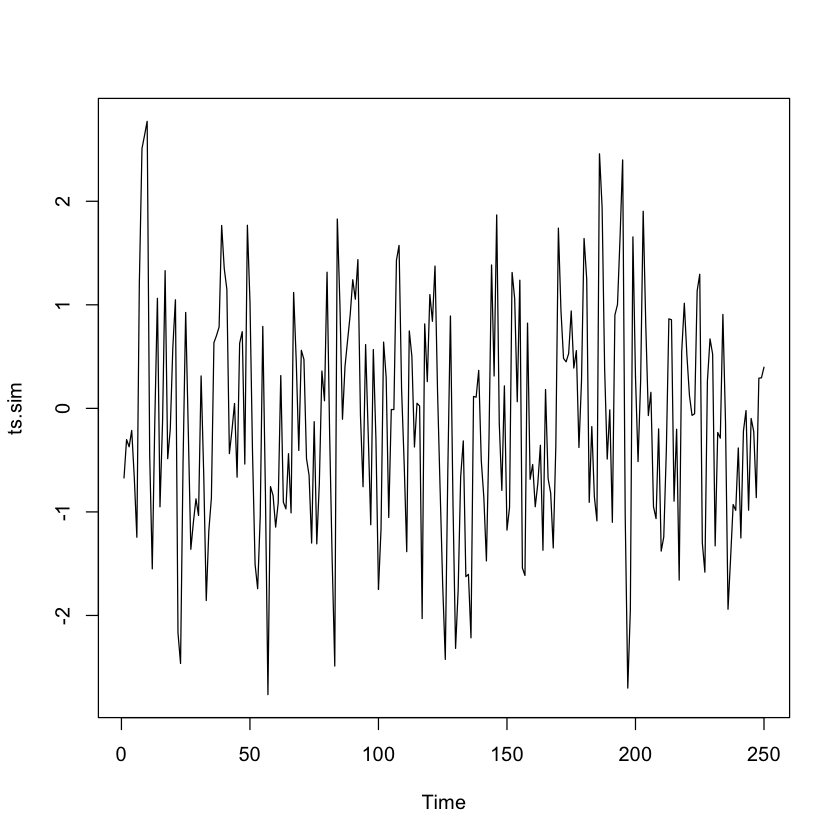

In [17]:
set.seed(345)

T.series <- 250

# simulate the MA(1) process - actual data
ts.sim <- arima.sim(n = T.series, model = list(ma = c(0.5)))

plot.ts(ts.sim)

Estimate the parameter of the auxiliary model $\hat{\rho}$.

In [18]:
# compute rho.hat under AR(1)
rho.hat <- sum(ts.sim[-1] * ts.sim[-length(ts.sim)]) / sum(ts.sim[-length(ts.sim)]^2)
rho.hat

[1] 0.3741677

Using the fact that the $y_t$ are MA(1) process, the relation between $\rho$ and $\theta$ is: 

$$
\theta = \frac{1 - \sqrt{1 - 4\rho^2}}{2 \rho} 
$$

To derive the result, just use the moment condition for estimation of $\rho$ and use the fact that $y_t$ is MA(1) process.

In [19]:
theta.hat <- (1 - sqrt(1 - 4 * rho.hat^2)) / (2 * rho.hat)
theta.hat

[1] 0.4499045

Define the function that will for given $\theta$ and simulated data (random disturbances) compute the squared difference between observed $\rho$ from the data, $\hat{\rho}$, and $\rho$ from the simulated dataset, $\hat{\rho_s}$ computed as mean over $n_{sim}$ simulations.

In [20]:
obj.func <- function(theta, data) {
  n.sim <- ncol(data)
  rho.sim <- rep(NA, n.sim)

  for (i in 1:n.sim) {
      e <- data[ , i]
      series <- e[-1] + theta * e[-length(e)]
      rho.sim[i] <- sum(series[-1] * series[-length(series)]) / sum(series[-length(series)]^2)
  }
  obj.val <- (rho.hat - mean(rho.sim))^2
  obj.val
}

And finally, find the value of $\theta$ that best fits the observed data.

In [21]:
# simulate the data for the estimation
set.seed(345)
n.sim <- 10000
data = matrix(rnorm(T.series * n.sim), ncol = n.sim)

# optimize over all the samples
est.res = optim(0, obj.func, data = data, method = "BFGS")
est.res

$par
[1] 0.4524793

$value
[1] 5.126774e-13

$counts
function gradient 
      31       13 

$convergence
[1] 0

$message
NULL